In [5]:
import os
import pandas as pd
from tqdm import tqdm
from google.cloud import translate_v2 as translate
import warnings
from dotenv import load_dotenv

load_dotenv()

warnings.filterwarnings('ignore')

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:\\Users\\169842\\Downloads\\thesis-445700-e18d2dc2f538.json"


In [21]:
df = pd.read_csv("data/full_tests/cleaned/beta_proportional_no_topic_snippet_author.csv")

In [26]:
def translate_text(text):
    """
    Translate text using Google Cloud Translation API.
    """
    translate_client = translate.Client()
    result = translate_client.translate(text, target_language='it')
    return result['translatedText']

In [27]:
tqdm.pandas()

In [28]:
df['title'] = df.progress_apply(
    lambda row: translate_text(row['title']) if row['newspaper'] in ['The Guardian', 'The New York Times'] else row['title'],
    axis=1
)

100%|██████████| 9514/9514 [22:07<00:00,  7.17it/s]   


In [31]:
df.to_csv("articoli_di_giornale_ita.csv")

In [49]:
df1 = pd.read_csv("articoli_di_giornale_ita.csv").drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

In [50]:
df1.drop_duplicates()

,newspaper,date,title,year,quarter
0,AI4Business,2022-03-30 00:00:00,"Visori di realtà aumentata: cosa sono, come fu...",2022,1
1,AI4Business,2022-03-29 00:00:00,Riconoscimento facciale: l'Ucraina utilizza Cl...,2022,1
2,AI4Business,2022-03-28 00:00:00,L’Unione europea a un punto di svolta nel proc...,2022,1
3,AI4Business,2022-03-25 00:00:00,"Il Natural Language Processing (NLP), tecnolog...",2022,1
4,AI4Business,2022-03-24 00:00:00,"Modelli ibridi per l’intelligenza artificiale,...",2022,1
...,...,...,...,...,...
9509,Wired,2024-10-02 00:00:00,La startup che vuole far guadagnare i creator ...,2024,4
9510,Wired,2024-10-01 00:00:00,Il Cybertruck ora si guida da solo,2024,4
9511,Wired,2024-10-01 00:00:00,Il nuovo Wired in edicola ci svela che cosa c'...,2024,4
9512,Wired,2024-10-01 00:00:00,3 startup che stanno usando l'AI per cambiare ...,2024,4


In [44]:
import stanza
from nltk.corpus import stopwords
import nltk

In [45]:
# Download required resources
nltk.download('stopwords')
stop_words = set(stopwords.words('italian'))

# Download and initialize the Stanza pipeline
stanza.download('it')
nlp = stanza.Pipeline(lang='it', processors='tokenize,mwt,pos,lemma,ner')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\169842\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-01-23 19:35:13 INFO: Downloaded file to C:\Users\169842\stanza_resources\resources.json
2025-01-23 19:35:13 INFO: Downloading default packages for language: it (Italian) ...
2025-01-23 19:35:51 INFO: Downloaded file to C:\Users\169842\stanza_resources\it\default.zip
2025-01-23 19:35:53 INFO: Finished downloading models and saved to C:\Users\169842\stanza_resources
2025-01-23 19:35:53 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-01-23 19:35:54 INFO: Downloaded file to C:\Users\169842\stanza_resources\resources.json
2025-01-23 19:35:54 INFO: Loading these models for language: it (Italian):
| Processor | Package           |
---------------------------------
| tokenize  | com

In [51]:

def process_text(text):
    doc = nlp(text)
    processed_tokens = []

    # Collect entities first
    entities = {ent.text: "_".join(ent.text.lower().split()) for ent in doc.ents}

    for sentence in doc.sentences:
        for word in sentence.words:
            # If the word is part of an entity, add the entity as a single token
            if word.text in entities:
                entity = entities[word.text]
                if entity not in processed_tokens:
                    processed_tokens.append(entity)
            # If not part of an entity, check stopwords and lemmatize
            elif word.text.lower() not in stop_words and word.upos != "PUNCT":
                processed_tokens.append(word.lemma)

    return processed_tokens

# Apply the processing function to the DataFrame
df1['processed_title'] = df1['title'].apply(process_text)

# Display the DataFrame
print(df1)

        newspaper                 date  \
0     AI4Business  2022-03-30 00:00:00   
1     AI4Business  2022-03-29 00:00:00   
2     AI4Business  2022-03-28 00:00:00   
3     AI4Business  2022-03-25 00:00:00   
4     AI4Business  2022-03-24 00:00:00   
...           ...                  ...   
9509        Wired  2024-10-02 00:00:00   
9510        Wired  2024-10-01 00:00:00   
9511        Wired  2024-10-01 00:00:00   
9512        Wired  2024-10-01 00:00:00   
9513        Wired  2024-10-01 00:00:00   

                                                  title  year  quarter  \
0     Visori di realtà aumentata: cosa sono, come fu...  2022        1   
1     Riconoscimento facciale: l'Ucraina utilizza Cl...  2022        1   
2     L’Unione europea a un punto di svolta nel proc...  2022        1   
3     Il Natural Language Processing (NLP), tecnolog...  2022        1   
4     Modelli ibridi per l’intelligenza artificiale,...  2022        1   
...                                                

In [54]:
df1.to_csv("articoli_di_giornale_ita_processed.csv")

In [11]:
from mistralai import Mistral, SDKError

In [12]:
csv_path = "articoli_di_giornale_ita_processed.csv"
df = pd.read_csv(csv_path).drop(columns=['Unnamed: 0']).drop_duplicates()
backup_path = "articoli_di_giornale_ita_processed_llm.csv"

In [13]:
if os.path.exists(backup_path):
    backup_df = pd.read_csv(backup_path)
    processed_indices = backup_df.index.tolist()
    df_to_process = df.drop(index=processed_indices)
    df = pd.concat([backup_df, df_to_process], ignore_index=True)
else:
    df['processed_with_llm'] = None


In [23]:
api_key = os.getenv("MISTRALAI_API_KEY")
agent_id = "ag:c752b29a:20250125:lemming:e9d6fa74"
client = Mistral(api_key=api_key)

In [28]:
import ast
import time

def process_text_with_llm(text: str, max_retries=5, delay=5) -> list:
    attempt = 0
    while attempt < max_retries:
        try:
            messages = [
                {
                    "role": "user",
                    "content": text
                }
            ]
            chat_response = client.agents.complete(
                agent_id=agent_id,
                messages=messages,
                max_tokens=150
            )
            response_content = chat_response.choices[0].message.content.strip()
            result_list = ast.literal_eval(response_content)
            return result_list
        except SDKError as sdk_err:
            print(f"SDKError: {sdk_err}")
            print(f"Status Code: {sdk_err.status_code}")
            print(f"Message: {sdk_err.message}")
            print(f"Request ID: {sdk_err.request_id}")
            if sdk_err.status_code == 401:
                raise ValueError("Verify API key is correct")
            attempt += 1
            print(f"Retrying in {delay} seconds... (Attempt {attempt}/{max_retries})")
            time.sleep(delay)
        except Exception as e:
            print(f"Unknown error: {e}")
            attempt += 1
            print(f"Retrying in {delay} seconds... (Attempt {attempt}/{max_retries})")
            time.sleep(delay)
    print("Max Retry Limit Exceeded, going to next row.")
    return []

In [29]:
def save_backup(df, path, start_idx, end_idx):
    df_subset = df.iloc[start_idx:end_idx]
    df_subset.to_csv(path, index=False)
    print(f"Backup created from {start_idx} to {end_idx}.")

In [30]:
batch_size = 50
total_rows = len(df)
current_index = 0

for index, row in tqdm(df.iterrows(), total=total_rows, desc="Processing rows"):
    if pd.isna(row['processed_with_llm']):
        processed_result = process_text_with_llm(row['title'])
        df.at[index, 'processed_with_llm'] = str(processed_result)

        current_index += 1

        if current_index % batch_size == 0:
            df.to_csv(backup_path, index=False)
            print(f"{current_index} processed rows saved.")

        time.sleep(5)

if current_index % batch_size != 0:
    df.to_csv(backup_path, index=False)
    print(f"All rows processed and saved to {backup_path}.")

print("Process Completed.")

Processing rows:   1%|          | 49/8903 [02:19<14:07:09,  5.74s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:   1%|          | 74/8903 [04:51<14:30:59,  5.92s/it]

50 processed rows saved.


Processing rows:   1%|▏         | 124/8903 [09:45<14:03:40,  5.77s/it]

100 processed rows saved.


Processing rows:   2%|▏         | 174/8903 [14:40<14:35:09,  6.02s/it]

150 processed rows saved.


Processing rows:   3%|▎         | 224/8903 [19:35<14:10:10,  5.88s/it]

200 processed rows saved.


Processing rows:   3%|▎         | 274/8903 [27:31<14:00:46,  5.85s/it]

250 processed rows saved.


Processing rows:   4%|▎         | 324/8903 [32:27<16:45:09,  7.03s/it]

300 processed rows saved.


Processing rows:   4%|▍         | 364/8903 [36:21<13:42:18,  5.78s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 2/5)


Processing rows:   4%|▍         | 374/8903 [37:32<14:28:42,  6.11s/it]

350 processed rows saved.


Processing rows:   5%|▍         | 406/8903 [40:38<13:41:29,  5.80s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:   5%|▍         | 424/8903 [42:33<13:55:31,  5.91s/it]

400 processed rows saved.


Processing rows:   5%|▌         | 474/8903 [47:28<13:51:59,  5.92s/it]

450 processed rows saved.


Processing rows:   6%|▌         | 524/8903 [53:21<13:32:09,  5.82s/it]

500 processed rows saved.


Processing rows:   6%|▋         | 574/8903 [59:19<13:37:05,  5.89s/it]

550 processed rows saved.


Processing rows:   7%|▋         | 624/8903 [1:04:19<13:22:25,  5.82s/it]

600 processed rows saved.


Processing rows:   8%|▊         | 673/8903 [1:09:13<13:20:40,  5.84s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:   8%|▊         | 674/8903 [1:09:24<17:25:54,  7.63s/it]

650 processed rows saved.


Processing rows:   8%|▊         | 724/8903 [1:14:25<13:05:44,  5.76s/it]

700 processed rows saved.


Processing rows:   8%|▊         | 730/8903 [1:14:59<12:53:41,  5.68s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 2/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 3/5)


Processing rows:   9%|▊         | 774/8903 [1:20:35<13:05:16,  5.80s/it]

750 processed rows saved.


Processing rows:   9%|▉         | 824/8903 [1:25:29<14:21:58,  6.40s/it]

800 processed rows saved.


Processing rows:  10%|▉         | 874/8903 [1:31:40<17:01:39,  7.63s/it]

850 processed rows saved.


Processing rows:  10%|█         | 924/8903 [1:37:37<13:41:57,  6.18s/it]

900 processed rows saved.


Processing rows:  11%|█         | 974/8903 [1:42:40<12:44:01,  5.78s/it]

950 processed rows saved.


Processing rows:  11%|█         | 980/8903 [1:43:19<13:39:02,  6.20s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  12%|█▏        | 1024/8903 [1:47:43<12:49:21,  5.86s/it]

1000 processed rows saved.


Processing rows:  12%|█▏        | 1050/8903 [1:50:18<13:52:17,  6.36s/it]

Unknown error: malformed node or string on line 1: <ast.Name object at 0x00000237207B1E90>
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  12%|█▏        | 1074/8903 [1:53:46<52:27:38, 24.12s/it]

1050 processed rows saved.


Processing rows:  13%|█▎        | 1124/8903 [1:58:39<12:37:07,  5.84s/it]

1100 processed rows saved.


Processing rows:  13%|█▎        | 1148/8903 [2:01:59<17:12:56,  7.99s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 2/5)


Processing rows:  13%|█▎        | 1174/8903 [2:04:42<12:24:43,  5.78s/it]

1150 processed rows saved.


Processing rows:  14%|█▎        | 1224/8903 [2:09:34<12:20:47,  5.79s/it]

1200 processed rows saved.


Processing rows:  14%|█▍        | 1274/8903 [2:14:29<12:18:21,  5.81s/it]

1250 processed rows saved.


Processing rows:  15%|█▍        | 1324/8903 [2:19:36<12:25:59,  5.91s/it]

1300 processed rows saved.


Processing rows:  15%|█▌        | 1337/8903 [2:20:58<13:00:03,  6.19s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  15%|█▌        | 1374/8903 [2:24:44<12:28:53,  5.97s/it]

1350 processed rows saved.


Processing rows:  16%|█▌        | 1424/8903 [2:29:38<12:09:33,  5.85s/it]

1400 processed rows saved.


Processing rows:  17%|█▋        | 1474/8903 [2:34:33<11:36:02,  5.62s/it]

1450 processed rows saved.


Processing rows:  17%|█▋        | 1524/8903 [2:39:22<12:06:48,  5.91s/it]

1500 processed rows saved.


Processing rows:  18%|█▊        | 1574/8903 [2:44:18<11:41:52,  5.75s/it]

1550 processed rows saved.


Processing rows:  18%|█▊        | 1624/8903 [2:49:23<11:59:25,  5.93s/it]

1600 processed rows saved.


Processing rows:  19%|█▉        | 1674/8903 [2:54:26<12:02:01,  5.99s/it]

1650 processed rows saved.


Processing rows:  19%|█▉        | 1710/8903 [2:59:05<12:43:24,  6.37s/it]

Unknown error: unterminated string literal (detected at line 3) (<unknown>, line 3)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 2/5)


Processing rows:  19%|█▉        | 1724/8903 [3:00:43<12:02:11,  6.04s/it]

1700 processed rows saved.


Processing rows:  20%|█▉        | 1774/8903 [3:07:47<11:49:16,  5.97s/it]

1750 processed rows saved.


Processing rows:  20%|██        | 1792/8903 [3:09:36<11:54:06,  6.03s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: unterminated string literal (detected at line 10) (<unknown>, line 10)
Retrying in 5 seconds... (Attempt 2/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 3/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 4/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 5/5)
Max Retry Limit Exceeded, going to next row.


Processing rows:  20%|██        | 1800/8903 [3:11:03<14:02:25,  7.12s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  20%|██        | 1824/8903 [3:13:34<11:46:58,  5.99s/it]

1800 processed rows saved.


Processing rows:  21%|██        | 1857/8903 [3:16:52<11:45:23,  6.01s/it]

Unknown error: unterminated string literal (detected at line 4) (<unknown>, line 4)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 2/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 3/5)
Unknown error: unterminated string literal (detected at line 4) (<unknown>, line 4)
Retrying in 5 seconds... (Attempt 4/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 5/5)
Max Retry Limit Exceeded, going to next row.


Processing rows:  21%|██        | 1874/8903 [3:19:13<11:44:35,  6.01s/it]

1850 processed rows saved.


Processing rows:  22%|██▏       | 1924/8903 [3:24:17<11:38:39,  6.01s/it]

1900 processed rows saved.


Processing rows:  22%|██▏       | 1953/8903 [3:29:18<11:59:00,  6.21s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: unterminated string literal (detected at line 8) (<unknown>, line 8)
Retrying in 5 seconds... (Attempt 2/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 3/5)
Unknown error: unterminated string literal (detected at line 3) (<unknown>, line 3)
Retrying in 5 seconds... (Attempt 4/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 5/5)
Max Retry Limit Exceeded, going to next row.


Processing rows:  22%|██▏       | 1974/8903 [3:32:03<11:33:47,  6.01s/it]

1950 processed rows saved.


Processing rows:  23%|██▎       | 2024/8903 [3:38:07<11:40:22,  6.11s/it]

2000 processed rows saved.


Processing rows:  23%|██▎       | 2067/8903 [3:42:28<11:27:49,  6.04s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 2/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 3/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 4/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 5/5)
Max Retry Limit Exceeded, going to next row.


Processing rows:  23%|██▎       | 2074/8903 [3:43:49<14:34:59,  7.69s/it]

2050 processed rows saved.


Processing rows:  24%|██▎       | 2102/8903 [3:46:39<11:16:40,  5.97s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 2/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 3/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 4/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 5/5)
Max Retry Limit Exceeded, going to next row.


Processing rows:  24%|██▍       | 2124/8903 [3:49:32<11:18:34,  6.01s/it]

2100 processed rows saved.


Processing rows:  24%|██▍       | 2174/8903 [3:54:35<11:28:59,  6.14s/it]

2150 processed rows saved.


Processing rows:  24%|██▍       | 2177/8903 [3:54:53<11:01:53,  5.90s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  25%|██▍       | 2224/8903 [3:59:51<11:25:15,  6.16s/it]

2200 processed rows saved.


Processing rows:  25%|██▌       | 2249/8903 [4:02:24<11:17:31,  6.11s/it]

Unknown error: malformed node or string on line 1: <ast.Name object at 0x0000023720566290>
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  25%|██▌       | 2256/8903 [4:03:12<11:32:31,  6.25s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 2/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 3/5)
Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 4/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 5/5)
Max Retry Limit Exceeded, going to next row.


Processing rows:  26%|██▌       | 2274/8903 [4:05:44<11:20:34,  6.16s/it]

2250 processed rows saved.


Processing rows:  26%|██▌       | 2324/8903 [4:10:53<11:23:54,  6.24s/it]

2300 processed rows saved.


Processing rows:  27%|██▋       | 2374/8903 [4:15:57<11:05:49,  6.12s/it]

2350 processed rows saved.


Processing rows:  27%|██▋       | 2424/8903 [4:21:05<10:58:41,  6.10s/it]

2400 processed rows saved.


Processing rows:  28%|██▊       | 2474/8903 [4:26:11<10:44:57,  6.02s/it]

2450 processed rows saved.


Processing rows:  28%|██▊       | 2524/8903 [4:31:19<10:50:02,  6.11s/it]

2500 processed rows saved.


Processing rows:  29%|██▉       | 2574/8903 [4:36:27<10:47:09,  6.14s/it]

2550 processed rows saved.


Processing rows:  29%|██▉       | 2601/8903 [4:40:12<10:19:01,  5.89s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  29%|██▉       | 2624/8903 [4:42:41<10:42:43,  6.14s/it]

2600 processed rows saved.


Processing rows:  30%|███       | 2674/8903 [4:47:49<10:29:07,  6.06s/it]

2650 processed rows saved.


Processing rows:  31%|███       | 2724/8903 [4:52:58<10:43:37,  6.25s/it]

2700 processed rows saved.


Processing rows:  31%|███       | 2774/8903 [4:58:04<10:31:00,  6.18s/it]

2750 processed rows saved.


Processing rows:  32%|███▏      | 2824/8903 [5:03:21<10:18:59,  6.11s/it]

2800 processed rows saved.


Processing rows:  32%|███▏      | 2874/8903 [5:08:27<10:10:12,  6.07s/it]

2850 processed rows saved.


Processing rows:  33%|███▎      | 2907/8903 [5:11:49<10:13:19,  6.14s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  33%|███▎      | 2924/8903 [5:13:39<10:07:48,  6.10s/it]

2900 processed rows saved.


Processing rows:  33%|███▎      | 2947/8903 [5:15:58<9:54:58,  5.99s/it] 

Unknown error: invalid syntax (<unknown>, line 2)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  33%|███▎      | 2974/8903 [5:18:51<9:59:03,  6.06s/it] 

2950 processed rows saved.


Processing rows:  34%|███▍      | 3024/8903 [5:24:01<9:51:16,  6.03s/it] 

3000 processed rows saved.


Processing rows:  35%|███▍      | 3074/8903 [5:29:11<11:32:14,  7.13s/it]

3050 processed rows saved.


Processing rows:  35%|███▌      | 3124/8903 [5:34:21<9:43:55,  6.06s/it] 

3100 processed rows saved.


Processing rows:  36%|███▌      | 3174/8903 [5:39:27<9:43:58,  6.12s/it] 

3150 processed rows saved.


Processing rows:  36%|███▌      | 3224/8903 [5:44:38<10:01:12,  6.35s/it]

3200 processed rows saved.


Processing rows:  37%|███▋      | 3274/8903 [5:49:48<9:50:35,  6.30s/it] 

3250 processed rows saved.


Processing rows:  37%|███▋      | 3324/8903 [5:54:58<9:26:27,  6.09s/it] 

3300 processed rows saved.


Processing rows:  38%|███▊      | 3374/8903 [6:00:08<9:34:13,  6.23s/it] 

3350 processed rows saved.


Processing rows:  38%|███▊      | 3407/8903 [6:03:28<9:09:05,  5.99s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 2/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 3/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 4/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 5/5)
Max Retry Limit Exceeded, going to next row.


Processing rows:  38%|███▊      | 3424/8903 [6:05:58<9:32:50,  6.27s/it] 

3400 processed rows saved.


Processing rows:  39%|███▉      | 3474/8903 [6:11:12<9:23:25,  6.23s/it] 

3450 processed rows saved.


Processing rows:  39%|███▉      | 3500/8903 [6:13:54<9:09:32,  6.10s/it] 

Unknown error: unterminated string literal (detected at line 8) (<unknown>, line 8)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 2/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 3/5)
Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 4/5)
Unknown error: unterminated string literal (detected at line 8) (<unknown>, line 8)
Retrying in 5 seconds... (Attempt 5/5)
Max Retry Limit Exceeded, going to next row.


Processing rows:  40%|███▉      | 3524/8903 [6:16:59<8:58:26,  6.01s/it] 

3500 processed rows saved.


Processing rows:  40%|████      | 3574/8903 [6:22:14<9:01:58,  6.10s/it] 

3550 processed rows saved.


Processing rows:  41%|████      | 3624/8903 [6:27:22<9:09:34,  6.25s/it]

3600 processed rows saved.


Processing rows:  41%|████      | 3653/8903 [6:30:22<8:58:08,  6.15s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  41%|████▏     | 3674/8903 [6:32:37<8:50:47,  6.09s/it] 

3650 processed rows saved.


Processing rows:  42%|████▏     | 3724/8903 [6:37:54<8:48:02,  6.12s/it] 

3700 processed rows saved.


Processing rows:  42%|████▏     | 3774/8903 [6:42:58<8:11:33,  5.75s/it]

3750 processed rows saved.


Processing rows:  43%|████▎     | 3824/8903 [6:47:52<8:10:38,  5.80s/it]

3800 processed rows saved.


Processing rows:  44%|████▎     | 3874/8903 [6:52:45<8:12:27,  5.88s/it]

3850 processed rows saved.


Processing rows:  44%|████▍     | 3924/8903 [6:57:39<7:51:06,  5.68s/it]

3900 processed rows saved.


Processing rows:  45%|████▍     | 3974/8903 [7:02:37<8:02:26,  5.87s/it]

3950 processed rows saved.


Processing rows:  45%|████▌     | 4024/8903 [7:07:31<7:58:11,  5.88s/it]

4000 processed rows saved.


Processing rows:  46%|████▌     | 4074/8903 [7:12:24<7:56:21,  5.92s/it]

4050 processed rows saved.


Processing rows:  46%|████▋     | 4124/8903 [7:17:21<7:31:06,  5.66s/it]

4100 processed rows saved.


Processing rows:  47%|████▋     | 4174/8903 [7:22:28<8:01:20,  6.11s/it] 

4150 processed rows saved.


Processing rows:  47%|████▋     | 4224/8903 [7:27:23<7:38:17,  5.88s/it]

4200 processed rows saved.


Processing rows:  48%|████▊     | 4258/8903 [7:30:43<7:32:24,  5.84s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  48%|████▊     | 4274/8903 [7:32:24<7:31:52,  5.86s/it]

4250 processed rows saved.


Processing rows:  49%|████▊     | 4324/8903 [7:37:19<7:32:39,  5.93s/it]

4300 processed rows saved.


Processing rows:  49%|████▉     | 4343/8903 [7:39:11<7:38:52,  6.04s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  49%|████▉     | 4358/8903 [7:40:51<7:45:10,  6.14s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  49%|████▉     | 4374/8903 [7:42:39<7:51:51,  6.25s/it] 

4350 processed rows saved.


Processing rows:  50%|████▉     | 4424/8903 [7:47:31<7:10:22,  5.77s/it]

4400 processed rows saved.


Processing rows:  50%|█████     | 4474/8903 [7:52:24<7:13:20,  5.87s/it]

4450 processed rows saved.


Processing rows:  51%|█████     | 4522/8903 [7:57:04<7:07:26,  5.85s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  51%|█████     | 4524/8903 [7:57:22<8:48:20,  7.24s/it]

4500 processed rows saved.


Processing rows:  51%|█████     | 4531/8903 [7:58:02<7:07:24,  5.87s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 2/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 3/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 4/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 5/5)
Max Retry Limit Exceeded, going to next row.


Processing rows:  51%|█████▏    | 4574/8903 [8:03:43<7:03:43,  5.87s/it] 

4550 processed rows saved.


Processing rows:  52%|█████▏    | 4624/8903 [8:09:46<7:01:53,  5.92s/it] 

4600 processed rows saved.


Processing rows:  52%|█████▏    | 4674/8903 [8:14:38<6:52:43,  5.86s/it]

4650 processed rows saved.


Processing rows:  53%|█████▎    | 4724/8903 [8:19:33<6:52:20,  5.92s/it]

4700 processed rows saved.


Processing rows:  54%|█████▎    | 4774/8903 [8:26:30<14:07:01, 12.31s/it]

4750 processed rows saved.


Processing rows:  54%|█████▍    | 4824/8903 [8:31:28<6:37:34,  5.85s/it] 

4800 processed rows saved.


Processing rows:  55%|█████▍    | 4874/8903 [8:36:26<6:47:13,  6.06s/it]

4850 processed rows saved.


Processing rows:  55%|█████▌    | 4924/8903 [8:41:22<6:40:39,  6.04s/it]

4900 processed rows saved.


Processing rows:  56%|█████▌    | 4974/8903 [8:46:17<6:22:10,  5.84s/it]

4950 processed rows saved.


Processing rows:  56%|█████▋    | 5024/8903 [8:51:12<6:16:58,  5.83s/it]

5000 processed rows saved.


Processing rows:  57%|█████▋    | 5074/8903 [8:56:05<6:07:54,  5.77s/it]

5050 processed rows saved.


Processing rows:  57%|█████▋    | 5117/8903 [9:00:19<6:18:07,  5.99s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  58%|█████▊    | 5123/8903 [9:00:59<6:23:01,  6.08s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 2/5)
Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 3/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 4/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 5/5)
Max Retry Limit Exceeded, going to next row.


Processing rows:  58%|█████▊    | 5124/8903 [9:01:37<16:26:19, 15.66s/it]

5100 processed rows saved.


Processing rows:  58%|█████▊    | 5174/8903 [9:06:30<6:10:57,  5.97s/it] 

5150 processed rows saved.


Processing rows:  59%|█████▊    | 5224/8903 [9:11:23<5:57:10,  5.83s/it]

5200 processed rows saved.


Processing rows:  59%|█████▉    | 5274/8903 [9:16:21<5:56:56,  5.90s/it]

5250 processed rows saved.


Processing rows:  60%|█████▉    | 5324/8903 [9:21:18<5:45:44,  5.80s/it]

5300 processed rows saved.


Processing rows:  60%|██████    | 5374/8903 [9:26:11<5:39:34,  5.77s/it]

5350 processed rows saved.


Processing rows:  61%|██████    | 5424/8903 [9:31:09<5:38:17,  5.83s/it]

5400 processed rows saved.


Processing rows:  61%|██████▏   | 5474/8903 [9:36:04<5:21:35,  5.63s/it]

5450 processed rows saved.


Processing rows:  62%|██████▏   | 5479/8903 [9:36:33<5:28:43,  5.76s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  62%|██████▏   | 5524/8903 [9:42:06<5:32:52,  5.91s/it] 

5500 processed rows saved.


Processing rows:  62%|██████▏   | 5528/8903 [9:42:30<5:26:26,  5.80s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  62%|██████▏   | 5548/8903 [9:44:35<5:40:47,  6.09s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  63%|██████▎   | 5574/8903 [9:47:16<5:36:53,  6.07s/it]

5550 processed rows saved.


Processing rows:  63%|██████▎   | 5588/8903 [9:48:42<5:24:30,  5.87s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  63%|██████▎   | 5624/8903 [9:52:20<5:14:39,  5.76s/it]

5600 processed rows saved.


Processing rows:  64%|██████▎   | 5674/8903 [9:59:20<7:59:12,  8.90s/it] 

5650 processed rows saved.


Processing rows:  64%|██████▍   | 5724/8903 [10:05:14<5:17:36,  5.99s/it] 

5700 processed rows saved.


Processing rows:  65%|██████▍   | 5774/8903 [10:10:11<5:14:16,  6.03s/it]

5750 processed rows saved.


Processing rows:  65%|██████▌   | 5824/8903 [10:15:08<5:06:40,  5.98s/it]

5800 processed rows saved.


Processing rows:  66%|██████▌   | 5874/8903 [10:20:19<4:54:14,  5.83s/it]

5850 processed rows saved.


Processing rows:  67%|██████▋   | 5924/8903 [10:25:22<4:47:54,  5.80s/it]

5900 processed rows saved.


Processing rows:  67%|██████▋   | 5974/8903 [10:30:15<4:43:50,  5.81s/it]

5950 processed rows saved.


Processing rows:  67%|██████▋   | 6001/8903 [10:32:53<4:42:58,  5.85s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  68%|██████▊   | 6024/8903 [10:35:16<4:46:30,  5.97s/it]

6000 processed rows saved.


Processing rows:  68%|██████▊   | 6074/8903 [10:40:11<4:34:32,  5.82s/it]

6050 processed rows saved.


Processing rows:  69%|██████▉   | 6124/8903 [10:45:07<4:26:32,  5.75s/it]

6100 processed rows saved.


Processing rows:  69%|██████▉   | 6174/8903 [10:50:01<4:32:43,  6.00s/it]

6150 processed rows saved.


Processing rows:  70%|██████▉   | 6224/8903 [10:55:57<4:28:36,  6.02s/it] 

6200 processed rows saved.


Processing rows:  70%|███████   | 6274/8903 [11:00:54<4:15:02,  5.82s/it]

6250 processed rows saved.


Processing rows:  71%|███████   | 6324/8903 [11:05:55<4:25:04,  6.17s/it]

6300 processed rows saved.


Processing rows:  72%|███████▏  | 6374/8903 [11:10:48<4:11:15,  5.96s/it]

6350 processed rows saved.


Processing rows:  72%|███████▏  | 6424/8903 [11:15:40<3:56:52,  5.73s/it]

6400 processed rows saved.


Processing rows:  73%|███████▎  | 6474/8903 [11:20:37<4:05:19,  6.06s/it]

6450 processed rows saved.


Processing rows:  73%|███████▎  | 6524/8903 [11:25:46<4:03:13,  6.13s/it]

6500 processed rows saved.


Processing rows:  74%|███████▍  | 6574/8903 [11:30:47<4:05:12,  6.32s/it]

6550 processed rows saved.


Processing rows:  74%|███████▍  | 6608/8903 [11:34:03<3:36:01,  5.65s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 2/5)


Processing rows:  74%|███████▍  | 6624/8903 [11:35:48<3:30:44,  5.55s/it]

6600 processed rows saved.


Processing rows:  75%|███████▍  | 6638/8903 [11:37:09<3:45:52,  5.98s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  75%|███████▍  | 6674/8903 [11:40:50<3:38:00,  5.87s/it]

6650 processed rows saved.


Processing rows:  75%|███████▌  | 6715/8903 [11:44:54<3:36:11,  5.93s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  76%|███████▌  | 6724/8903 [11:45:54<3:35:38,  5.94s/it]

6700 processed rows saved.


Processing rows:  76%|███████▌  | 6727/8903 [11:46:12<3:31:40,  5.84s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 2/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 3/5)
Unknown error: unterminated string literal (detected at line 3) (<unknown>, line 3)
Retrying in 5 seconds... (Attempt 4/5)
Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 5/5)
Max Retry Limit Exceeded, going to next row.


Processing rows:  76%|███████▌  | 6774/8903 [11:51:19<3:27:34,  5.85s/it]

6750 processed rows saved.


Processing rows:  77%|███████▋  | 6824/8903 [11:56:14<3:21:55,  5.83s/it]

6800 processed rows saved.


Processing rows:  77%|███████▋  | 6874/8903 [12:02:10<3:54:35,  6.94s/it] 

6850 processed rows saved.


Processing rows:  78%|███████▊  | 6924/8903 [12:06:59<3:07:00,  5.67s/it]

6900 processed rows saved.


Processing rows:  78%|███████▊  | 6967/8903 [12:11:11<3:06:33,  5.78s/it]

Unknown error: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  78%|███████▊  | 6974/8903 [12:11:58<3:14:09,  6.04s/it]

6950 processed rows saved.


Processing rows:  78%|███████▊  | 6979/8903 [12:12:28<3:13:43,  6.04s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 2/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 3/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 4/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 5/5)
Max Retry Limit Exceeded, going to next row.


Processing rows:  79%|███████▉  | 7024/8903 [12:17:18<3:04:54,  5.90s/it]

7000 processed rows saved.


Processing rows:  79%|███████▉  | 7074/8903 [12:22:08<2:52:48,  5.67s/it]

7050 processed rows saved.


Processing rows:  80%|████████  | 7124/8903 [12:29:02<3:03:17,  6.18s/it] 

7100 processed rows saved.


Processing rows:  81%|████████  | 7174/8903 [12:33:57<2:47:20,  5.81s/it]

7150 processed rows saved.


Processing rows:  81%|████████  | 7224/8903 [12:39:48<2:43:25,  5.84s/it] 

7200 processed rows saved.


Processing rows:  82%|████████▏ | 7274/8903 [12:44:45<2:37:05,  5.79s/it]

7250 processed rows saved.


Processing rows:  82%|████████▏ | 7324/8903 [12:49:31<2:30:36,  5.72s/it]

7300 processed rows saved.


Processing rows:  83%|████████▎ | 7374/8903 [12:54:24<2:25:08,  5.70s/it]

7350 processed rows saved.


Processing rows:  83%|████████▎ | 7424/8903 [12:59:11<2:21:39,  5.75s/it]

7400 processed rows saved.


Processing rows:  84%|████████▍ | 7474/8903 [13:03:57<2:17:17,  5.76s/it]

7450 processed rows saved.


Processing rows:  85%|████████▍ | 7524/8903 [13:08:45<2:11:31,  5.72s/it]

7500 processed rows saved.


Processing rows:  85%|████████▌ | 7574/8903 [13:13:31<2:08:58,  5.82s/it]

7550 processed rows saved.


Processing rows:  86%|████████▌ | 7624/8903 [13:18:20<2:03:31,  5.80s/it]

7600 processed rows saved.


Processing rows:  86%|████████▌ | 7674/8903 [13:23:10<1:57:34,  5.74s/it]

7650 processed rows saved.


Processing rows:  86%|████████▌ | 7677/8903 [13:23:27<1:57:12,  5.74s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 2/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 3/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 4/5)
Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 5/5)
Max Retry Limit Exceeded, going to next row.


Processing rows:  87%|████████▋ | 7724/8903 [13:28:37<1:51:50,  5.69s/it]

7700 processed rows saved.


Processing rows:  87%|████████▋ | 7774/8903 [13:33:28<1:50:19,  5.86s/it]

7750 processed rows saved.


Processing rows:  87%|████████▋ | 7787/8903 [13:34:41<1:45:12,  5.66s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  88%|████████▊ | 7824/8903 [13:38:19<1:42:44,  5.71s/it]

7800 processed rows saved.


Processing rows:  88%|████████▊ | 7848/8903 [13:40:37<1:41:15,  5.76s/it]

Unknown error: malformed node or string on line 1: <ast.Name object at 0x000002371F0EF610>
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  88%|████████▊ | 7874/8903 [13:43:11<1:37:50,  5.70s/it]

7850 processed rows saved.


Processing rows:  89%|████████▉ | 7924/8903 [13:48:03<1:34:54,  5.82s/it]

7900 processed rows saved.


Processing rows:  89%|████████▉ | 7954/8903 [13:50:59<1:32:34,  5.85s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  90%|████████▉ | 7974/8903 [13:53:00<1:27:57,  5.68s/it]

7950 processed rows saved.


Processing rows:  90%|████████▉ | 8005/8903 [13:55:59<1:25:33,  5.72s/it]

Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)
Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 2/5)
Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 3/5)
Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 4/5)
Unknown error: unterminated string literal (detected at line 1) (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 5/5)
Max Retry Limit Exceeded, going to next row.


Processing rows:  90%|█████████ | 8024/8903 [13:58:24<1:25:12,  5.82s/it]

8000 processed rows saved.


Processing rows:  91%|█████████ | 8074/8903 [14:03:12<1:19:10,  5.73s/it]

8050 processed rows saved.


Processing rows:  91%|█████████▏| 8124/8903 [14:08:04<1:13:09,  5.64s/it]

8100 processed rows saved.


Processing rows:  92%|█████████▏| 8174/8903 [14:12:55<1:11:52,  5.92s/it]

8150 processed rows saved.


Processing rows:  92%|█████████▏| 8222/8903 [14:17:31<1:04:48,  5.71s/it]

Unknown error: invalid syntax (<unknown>, line 1)
Retrying in 5 seconds... (Attempt 1/5)


Processing rows:  92%|█████████▏| 8224/8903 [14:17:48<1:19:26,  7.02s/it]

8200 processed rows saved.


Processing rows:  93%|█████████▎| 8274/8903 [14:22:34<1:00:13,  5.74s/it]

8250 processed rows saved.


Processing rows:  93%|█████████▎| 8324/8903 [14:27:20<54:57,  5.69s/it]  

8300 processed rows saved.


Processing rows:  94%|█████████▍| 8374/8903 [14:32:14<53:36,  6.08s/it]

8350 processed rows saved.


Processing rows:  95%|█████████▍| 8424/8903 [14:37:07<46:12,  5.79s/it]

8400 processed rows saved.


Processing rows:  95%|█████████▌| 8474/8903 [14:42:02<43:25,  6.07s/it]

8450 processed rows saved.


Processing rows:  96%|█████████▌| 8524/8903 [14:49:54<36:29,  5.78s/it]  

8500 processed rows saved.


Processing rows:  96%|█████████▋| 8574/8903 [14:55:43<30:50,  5.62s/it]  

8550 processed rows saved.


Processing rows:  97%|█████████▋| 8624/8903 [15:00:38<28:24,  6.11s/it]

8600 processed rows saved.


Processing rows:  97%|█████████▋| 8674/8903 [15:05:29<22:14,  5.83s/it]

8650 processed rows saved.


Processing rows:  98%|█████████▊| 8724/8903 [15:10:20<17:50,  5.98s/it]

8700 processed rows saved.


Processing rows:  99%|█████████▊| 8774/8903 [15:15:11<12:26,  5.79s/it]

8750 processed rows saved.


Processing rows:  99%|█████████▉| 8824/8903 [15:20:00<07:44,  5.88s/it]

8800 processed rows saved.


Processing rows: 100%|█████████▉| 8874/8903 [15:24:48<02:44,  5.68s/it]

8850 processed rows saved.


Processing rows: 100%|██████████| 8903/8903 [15:27:37<00:00,  6.25s/it]

All rows processed and saved to articoli_di_giornale_ita_processed_llm.csv.
Process Completed.


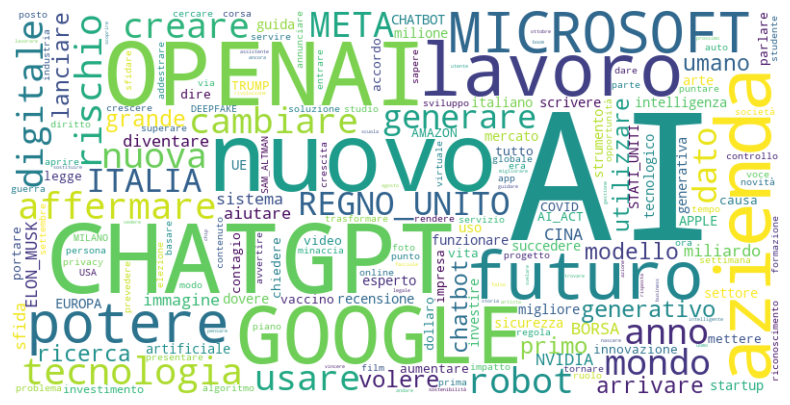

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np

df_to_mca = pd.read_csv("articoli_di_giornale_ita_mca.csv")
# df_to_mca = df_to_mca[~df_to_mca['lemma'].isin(['avere', 'essere', 'cosa', 'fare'])]
# df_to_mca['lemma'] = df_to_mca['lemma'].replace("risk", "rischio", regex=False)
# df_to_mca.to_csv("articoli_di_giornale_ita_mca.csv")
all_lemmas = df_to_mca['lemma'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x).str.split().explode()

frequencies = Counter(all_lemmas)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(frequencies)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [53]:
def correspondence_analysis(df_to_mca,
                                 top_lemmas_for_analysis=50,
                                 lemmas_to_plot=30,
                                 required_lemmas=None,
                                 figsize=(12, 8)):
    if required_lemmas is None:
        required_lemmas = ["rischio", "futuro", "investimento"]

    # Filter out numerical lemmas
    df_to_mca = df_to_mca[~df_to_mca['lemma'].str.match(r'^\d+$')]

    # Create initial contingency table
    full_contingency_table = pd.crosstab(df_to_mca['period'], df_to_mca['lemma'])

    # Select top N most frequent lemmas for analysis
    lemma_frequencies = full_contingency_table.sum()
    top_lemmas = lemma_frequencies.nlargest(top_lemmas_for_analysis).index
    contingency_table = full_contingency_table[top_lemmas]

    print(f"Analyzing top {top_lemmas_for_analysis} most frequent lemmas")
    print(f"Will plot top {lemmas_to_plot} contributing lemmas plus required lemmas: {required_lemmas}")

    # Step 1: Normalize the contingency table
    grand_total = contingency_table.values.sum()
    relative_frequencies = contingency_table / grand_total

    # Step 2: Compute row and column profiles
    row_totals = relative_frequencies.sum(axis=1).values.reshape(-1, 1)
    col_totals = relative_frequencies.sum(axis=0).values.reshape(1, -1)

    row_profiles = relative_frequencies.div(row_totals[:, 0], axis=0)
    col_profiles = relative_frequencies.div(col_totals[0, :], axis=1)

    # Step 3: Calculate the correspondence matrix
    correspondence_matrix = (relative_frequencies - row_totals @ col_totals) / np.sqrt(row_totals @ col_totals)

    # Step 4: Perform SVD
    U, S, VT = np.linalg.svd(correspondence_matrix, full_matrices=False)

    # Calculate eigenvalues and inertia
    eigenvalues = S**2
    total_inertia = np.sum(eigenvalues)
    explained_inertia = eigenvalues / total_inertia

    # Calculate coordinates for rows and columns
    row_coords = U[:, :2] * S[:2]
    col_coords = VT.T[:, :2] * S[:2]

    # Calculate contributions of each point to the axes
    lemma_contributions = np.sum(col_coords**2, axis=1)
    top_indices = np.argsort(lemma_contributions)[-lemmas_to_plot:]

    # Add required lemmas if they're not already in top lemmas
    required_indices = []
    for lemma in required_lemmas:
        if lemma in contingency_table.columns:
            idx = contingency_table.columns.get_loc(lemma)
            if idx not in top_indices:
                required_indices.append(idx)

    # Combine indices for plotting
    plot_indices = np.unique(np.concatenate([top_indices, required_indices]))

    # Create the plot
    plt.figure(figsize=figsize)

    # Extract coordinates
    row_x, row_y = row_coords[:, 0], row_coords[:, 1]
    col_x, col_y = col_coords[:, 0], col_coords[:, 1]

    # Plot topics (rows)
    plt.scatter(row_x, row_y, color='blue', label='Periods', alpha=0.7)
    for i, period in enumerate(contingency_table.index):
        plt.text(row_x[i], row_y[i], period, color='blue', fontsize=10)

    # Plot selected lemmas (columns)
    plt.scatter(col_x[plot_indices], col_y[plot_indices],
                color='red', label='Lemmas', marker='^', alpha=0.7)

    # Add labels for lemmas
    for idx in plot_indices:
        lemma = contingency_table.columns[idx]
        color = 'darkred' if lemma in required_lemmas else 'red'
        fontweight = 'bold' if lemma in required_lemmas else 'normal'
        plt.text(col_x[idx], col_y[idx], lemma,
                 color=color, fontsize=10, fontweight=fontweight)

    # Add plot details
    plt.axhline(0, color='black', linewidth=0.5, linestyle='dashed')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='dashed')
    plt.title('Correspondence Analysis Map', fontsize=14)
    plt.xlabel(f'Dimension 1 ({explained_inertia[0]:.2%})', fontsize=12)
    plt.ylabel(f'Dimension 2 ({explained_inertia[1]:.2%})', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    # Print explained inertia
    print(f"\nExplained inertia dimension 1: {explained_inertia[0]:.2%}")
    print(f"Explained inertia dimension 2: {explained_inertia[1]:.2%}")
    print(f"Total explained inertia: {explained_inertia[0] + explained_inertia[1]:.2%}")

    return plt

Analyzing top 50 most frequent lemmas
Will plot top 30 contributing lemmas plus required lemmas: ['rischio', 'futuro', 'investimento']

Explained inertia dimension 1: 33.61%
Explained inertia dimension 2: 21.82%
Total explained inertia: 55.43%


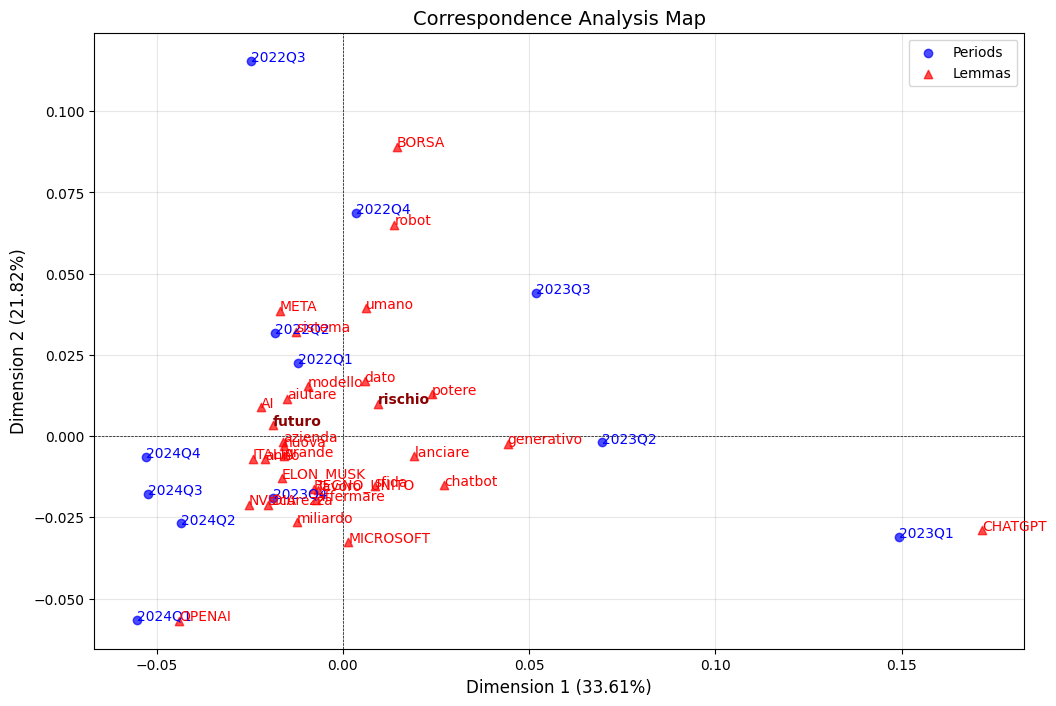

In [54]:
plot = correspondence_analysis(
    df_to_mca,
    top_lemmas_for_analysis=50,
    lemmas_to_plot=30,
    required_lemmas=["rischio", "futuro", "investimento"]
)
plt.show()

In [55]:
# Extract the year (the first 4 digits) from the 'period' column
df_to_mca['year'] = df_to_mca['period'].str.extract(r'(\d{4})')

Analyzing top 50 most frequent lemmas
Will plot top 30 contributing lemmas plus required lemmas: ['rischio', 'futuro', 'investimento']

Explained inertia dimension 1: 57.64%
Explained inertia dimension 2: 30.80%
Total explained inertia: 88.44%
Analyzing top 50 most frequent lemmas
Will plot top 30 contributing lemmas plus required lemmas: ['rischio', 'futuro', 'investimento']

Explained inertia dimension 1: 54.78%
Explained inertia dimension 2: 29.09%
Total explained inertia: 83.87%
Analyzing top 50 most frequent lemmas
Will plot top 30 contributing lemmas plus required lemmas: ['rischio', 'futuro', 'investimento']

Explained inertia dimension 1: 49.38%
Explained inertia dimension 2: 29.01%
Total explained inertia: 78.39%


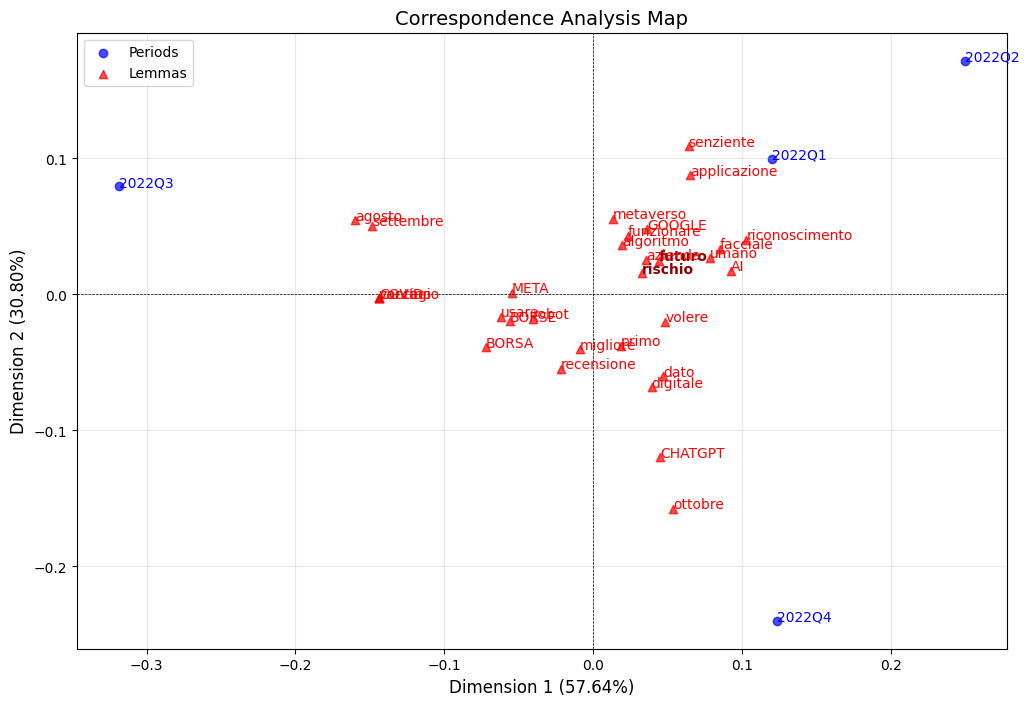

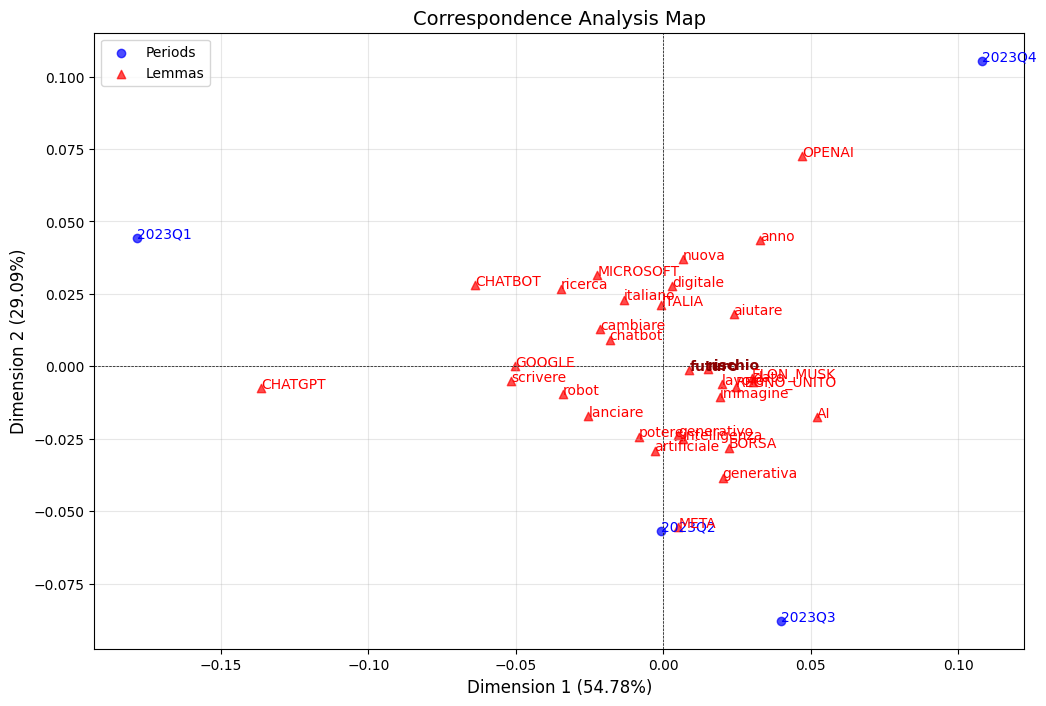

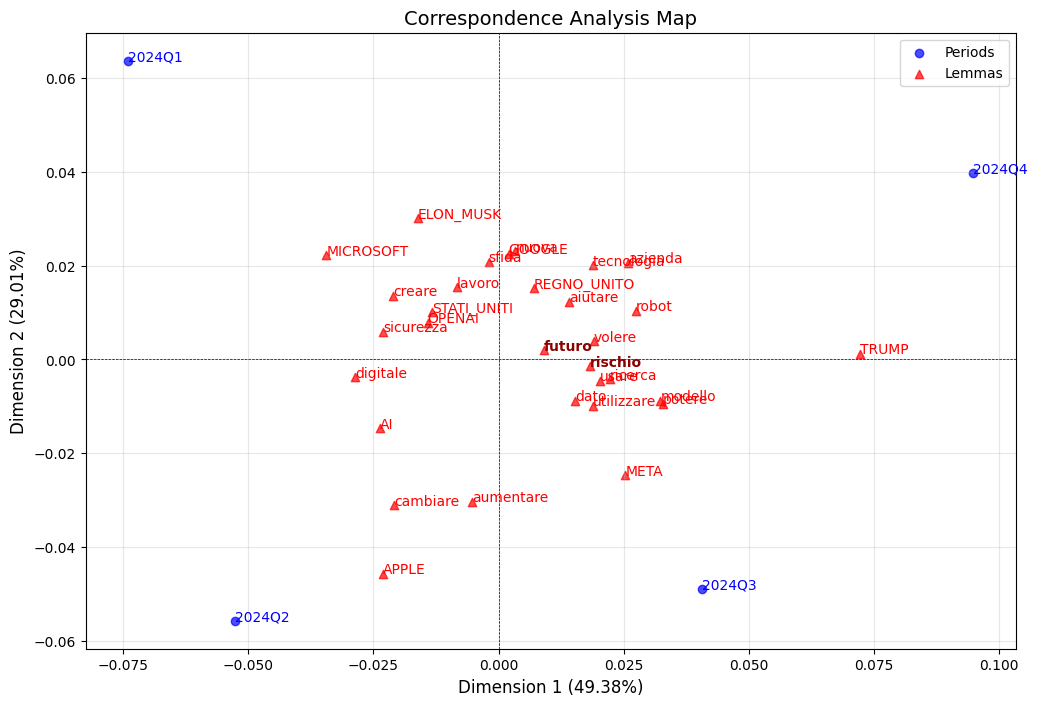

In [56]:
# Get unique years
years = df_to_mca['year'].unique()

# Use the same top lemmas from the general MCA (or recalculate per year)
top_lemmas_general = df_to_mca['lemma'].value_counts().head(200).index

for year in years:
    # Filter data for the current year
    df_year = df_to_mca[df_to_mca['year'] == year]

    plot = correspondence_analysis(
        df_year,
        top_lemmas_for_analysis=50,
        lemmas_to_plot=30,
        required_lemmas=["rischio", "futuro", "investimento"]
    )
plt.show()


# Creation of topics df generated in a [Colab Notebook](https://colab.research.google.com/drive/1HDIBWZjm9zTUpDH4-tWmJNks1qrvxpKe?usp=sharing) #

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [57]:
def more_correspondence_analysis(df,
                                     columns_to_analyze,
                                     top_lemmas_for_analysis=50,
                                     lemmas_to_plot=30,
                                     required_lemmas=None,
                                     figsize=(12, 8)):
    # Set default required lemmas if none provided
    if required_lemmas is None:
        required_lemmas = ["rischio", "futuro", "investire"]

    # Verify all requested columns exist in DataFrame
    if not all(col in df.columns for col in columns_to_analyze):
        missing_cols = [col for col in columns_to_analyze if col not in df.columns]
        raise ValueError(f"Columns not found in DataFrame: {missing_cols}")

    # Create working copy of the DataFrame
    df_analysis = df.copy()

    # Apply lemma-specific preprocessing if lemma column is included
    if 'lemma' in columns_to_analyze:
        # Remove numerical lemmas
        df_analysis = df_analysis[~df_analysis['lemma'].str.match(r'^\d+$')]

        # Select top N most frequent lemmas
        lemma_counts = df_analysis['lemma'].value_counts()
        top_lemmas = lemma_counts.nlargest(top_lemmas_for_analysis).index

        # Combine top lemmas with required lemmas
        all_lemmas = set(top_lemmas) | set(required_lemmas)
        df_analysis = df_analysis[df_analysis['lemma'].isin(all_lemmas)]

    # Generate contingency tables for all column pairs
    contingency_tables = []
    for i, col1 in enumerate(columns_to_analyze[:-1]):
        for col2 in columns_to_analyze[i+1:]:
            cont_table = pd.crosstab(df_analysis[col1], df_analysis[col2])
            contingency_tables.append((col1, col2, cont_table))

    # Process each contingency table
    results = []
    for col1, col2, contingency_table in contingency_tables:
        print(f"\nAnalyzing correspondence between {col1} and {col2}")

        # Normalize contingency table
        grand_total = contingency_table.values.sum()
        relative_frequencies = contingency_table / grand_total

        # Calculate row and column profiles
        row_totals = relative_frequencies.sum(axis=1).values.reshape(-1, 1)
        col_totals = relative_frequencies.sum(axis=0).values.reshape(1, -1)

        # Compute correspondence matrix
        correspondence_matrix = (relative_frequencies - row_totals @ col_totals) / np.sqrt(row_totals @ col_totals)

        # Perform Singular Value Decomposition
        U, S, VT = np.linalg.svd(correspondence_matrix, full_matrices=False)

        # Calculate eigenvalues and explained inertia
        eigenvalues = S**2
        total_inertia = np.sum(eigenvalues)
        explained_inertia = eigenvalues / total_inertia

        # Calculate coordinates for visualization
        row_coords = U[:, :2] * S[:2]
        col_coords = VT.T[:, :2] * S[:2]

        # Create visualization
        plt.figure(figsize=figsize)

        # Function to handle lemma plotting
        def plot_lemma_points(coords, labels, is_row=True):
            # Calculate contributions and select top contributors
            contributions = np.sum(coords**2, axis=1)
            n_to_plot = min(lemmas_to_plot, len(labels))
            top_indices = np.argsort(contributions)[-n_to_plot:]

            # Add required lemmas if specified
            required_indices = []
            if required_lemmas:
                for lemma in required_lemmas:
                    if lemma in labels:
                        idx = labels.get_loc(lemma)
                        if idx not in top_indices:
                            required_indices.append(idx)

            # Combine indices while maintaining total count
            if required_indices:
                n_required = len(required_indices)
                top_indices = top_indices[-(n_to_plot-n_required):]
                plot_indices = np.concatenate([top_indices, required_indices])
            else:
                plot_indices = top_indices

            # Plot points
            color = 'blue' if is_row else 'red'
            marker = 'o' if is_row else '^'
            plt.scatter(coords[plot_indices, 0], coords[plot_indices, 1],
                        color=color, label='Lemmas', marker=marker, alpha=0.7)

            # Add labels
            for idx in plot_indices:
                lemma = labels[idx]
                fontweight = 'bold' if lemma in required_lemmas else 'normal'
                plt.text(coords[idx, 0], coords[idx, 1], lemma,
                         color=color, fontsize=10, fontweight=fontweight)

        # Plot points based on whether they are lemmas or not
        if col1 == 'lemma':
            plot_lemma_points(row_coords, contingency_table.index, is_row=True)
        else:
            plt.scatter(row_coords[:, 0], row_coords[:, 1],
                        color='blue', label=f'{col1}', alpha=0.7)
            for i, label in enumerate(contingency_table.index):
                plt.text(row_coords[i, 0], row_coords[i, 1], str(label),
                         color='blue', fontsize=10)

        if col2 == 'lemma':
            plot_lemma_points(col_coords, contingency_table.columns, is_row=False)
        else:
            plt.scatter(col_coords[:, 0], col_coords[:, 1],
                        color='red', label=f'{col2}', marker='^', alpha=0.7)
            for i, label in enumerate(contingency_table.columns):
                plt.text(col_coords[i, 0], col_coords[i, 1], str(label),
                         color='red', fontsize=10)

        # Add plot styling
        plt.axhline(0, color='black', linewidth=0.5, linestyle='dashed')
        plt.axvline(0, color='black', linewidth=0.5, linestyle='dashed')
        plt.title(f'Correspondence Analysis: {col1} vs {col2}', fontsize=14)
        plt.xlabel(f'Dimension 1 ({explained_inertia[0]:.2%})', fontsize=12)
        plt.ylabel(f'Dimension 2 ({explained_inertia[1]:.2%})', fontsize=12)
        plt.legend()
        plt.grid(alpha=0.3)

        # Print explained variance information
        print(f"Explained inertia dimension 1: {explained_inertia[0]:.2%}")
        print(f"Explained inertia dimension 2: {explained_inertia[1]:.2%}")
        print(f"Total explained inertia: {explained_inertia[0] + explained_inertia[1]:.2%}")

        results.append((col1, col2, plt))

    return results


Analyzing correspondence between period and lemma
Explained inertia dimension 1: 33.54%
Explained inertia dimension 2: 21.62%
Total explained inertia: 55.16%

Analyzing correspondence between period and topic
Explained inertia dimension 1: 29.53%
Explained inertia dimension 2: 23.28%
Total explained inertia: 52.80%

Analyzing correspondence between lemma and topic
Explained inertia dimension 1: 26.06%
Explained inertia dimension 2: 22.01%
Total explained inertia: 48.07%


[('period',
  'lemma',
  <module 'matplotlib.pyplot' from 'D:\\PycharmProjects\\Thesis\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>),
 ('period',
  'topic',
  <module 'matplotlib.pyplot' from 'D:\\PycharmProjects\\Thesis\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>),
 ('lemma',
  'topic',
  <module 'matplotlib.pyplot' from 'D:\\PycharmProjects\\Thesis\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>)]

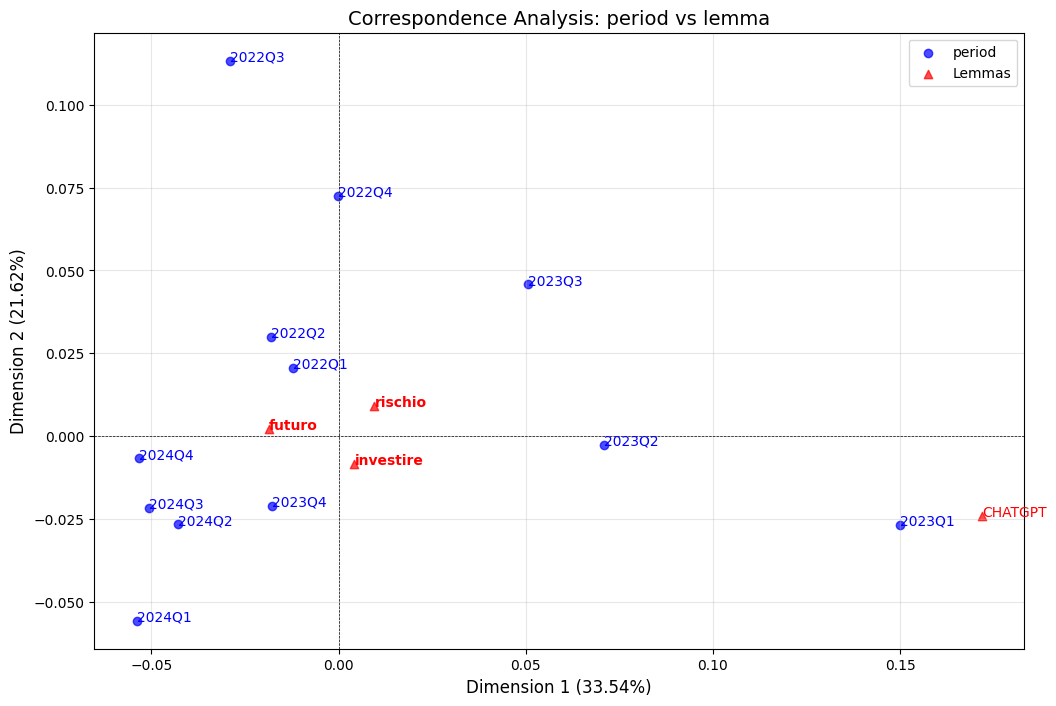

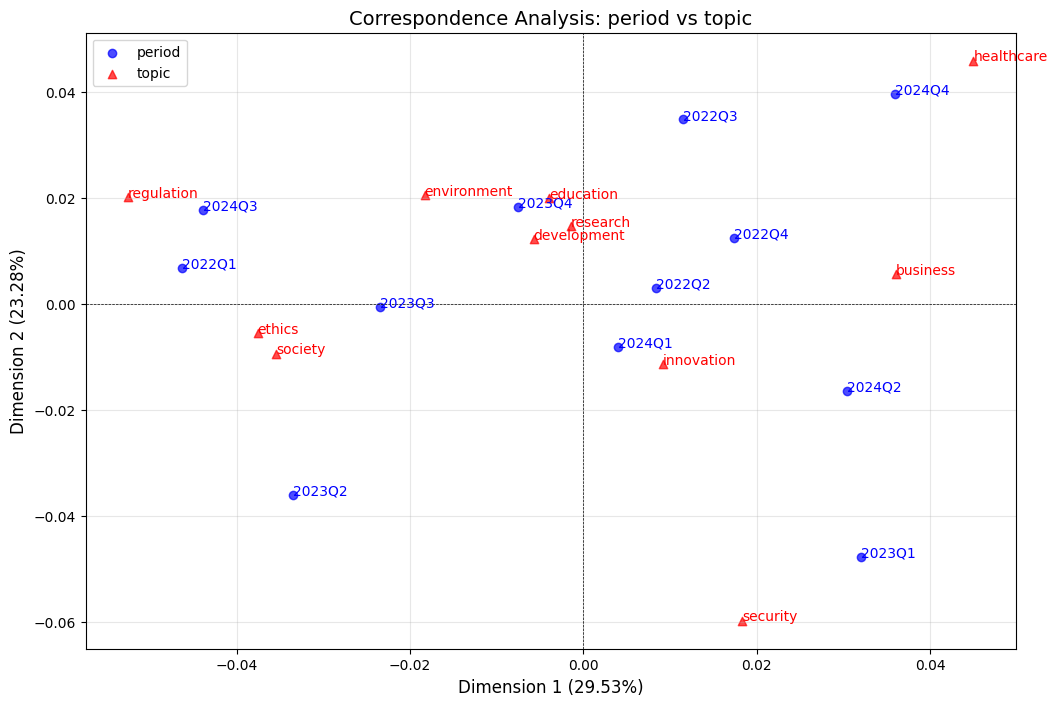

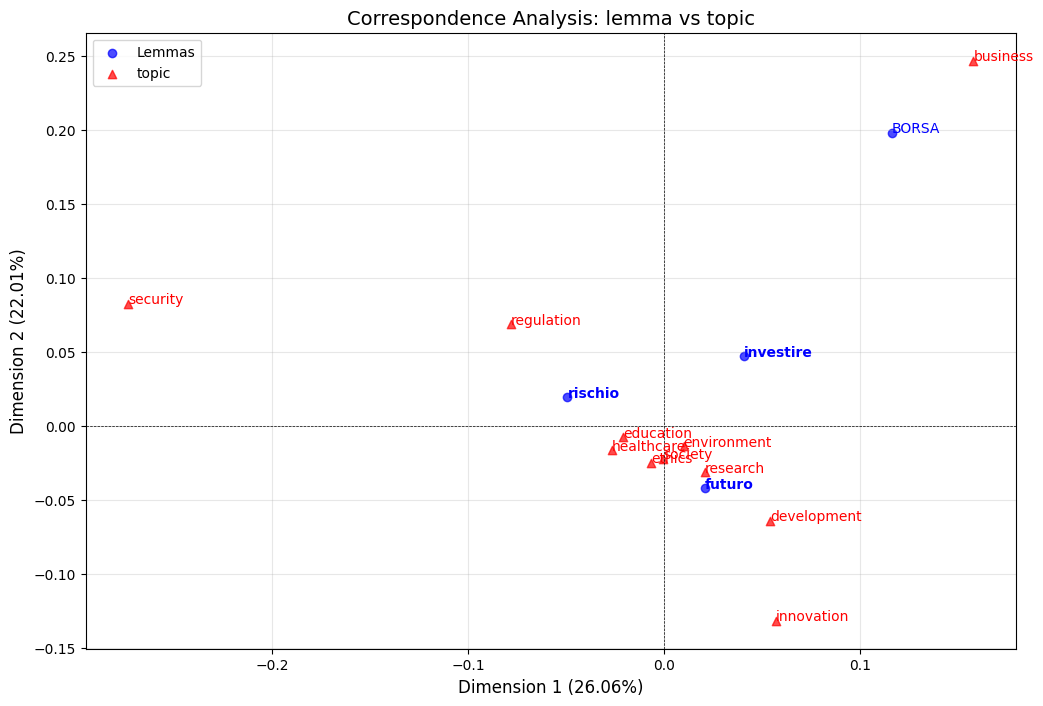

In [58]:
columns_to_analyze = ['period', 'lemma', 'topic']
more_correspondence_analysis(df=df_to_mca,
                                 columns_to_analyze=columns_to_analyze,
                                 top_lemmas_for_analysis=50,
                                 lemmas_to_plot=2)

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prince

def prince_multiple_correspondence_analysis(
        df,
        columns_to_analyze,
        top_lemmas_for_analysis=50,
        lemmas_to_plot=30,
        required_lemmas=None,
        n_components=None,
        variance_threshold=0.80,
        figsize=(12, 8)
):
    # Set default required lemmas if not provided
    if required_lemmas is None:
        required_lemmas = ["rischio", "futuro", "investire"]

    # Create a copy of the dataframe for safety
    df_analysis = df.copy()

    # If the 'lemma' column is present, apply filtering/limitations
    if 'lemma' in columns_to_analyze:
        # Remove purely numerical lemmas
        df_analysis = df_analysis[~df_analysis['lemma'].str.match(r'^\d+$')]

        # Get the most frequent lemmas (based on raw frequency count)
        lemma_counts = df_analysis['lemma'].value_counts()
        top_lemmas = lemma_counts.nlargest(top_lemmas_for_analysis).index

        # Merge top lemmas with 'required_lemmas'
        all_lemmas = set(top_lemmas) | set(required_lemmas)
        df_analysis = df_analysis[df_analysis['lemma'].isin(all_lemmas)]

    # 1) Fit an initial MCA with a large number of components
    #    Here we use (number_of_columns - 1) as a simple upper bound.
    #    You can increase it if needed, depending on the total number of categories.
    max_components = max(len(columns_to_analyze) - 1, 2)  # ensure at least 2
    mca_temp = prince.MCA(n_components=max_components, random_state=42)
    mca_temp.fit(df_analysis[columns_to_analyze])

    # 2) Compute the cumulative explained variance (inertia)
    eigenvalues = mca_temp.eigenvalues_  # inertia for each component
    total_inertia = sum(eigenvalues)
    explained_inertia_ratio = eigenvalues / total_inertia
    cumulative_inertia_ratio = np.cumsum(explained_inertia_ratio)
    if n_components is None:
        # 3) Find the smallest number of components that exceeds the given threshold
        n_components_opt = np.argmax(cumulative_inertia_ratio >= variance_threshold) + 1
    else:
        n_components_opt = n_components

    print(f"Automatic selection of n_components: {n_components_opt} "
          f"(to exceed {variance_threshold*100:.0f}% inertia)")

    # 4) Re-fit the MCA with the selected number of components
    mca = prince.MCA(n_components=n_components_opt, random_state=42)
    mca.fit(df_analysis[columns_to_analyze])

    # Extract MCA coordinates for all categories (columns)
    coordinates = mca.column_coordinates(df_analysis[columns_to_analyze])

    d = coordinates.shape[0] - len(columns_to_analyze)

    # Benzécri correction
    corrected_eigenvalues = (d / (d - 1)) * (eigenvalues - (1 / d))
    corrected_eigenvalues = np.maximum(corrected_eigenvalues, 0)  # Ensure non-negative values
    total_inertia = np.sum(corrected_eigenvalues)
    explained_inertia_ratio = corrected_eigenvalues / total_inertia
    explained_variance_ratio = explained_inertia_ratio

    # Create the plot (we visualize only the first 2 components)
    fig, ax = plt.subplots(figsize=figsize)

    # Define colors and markers for different columns
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    markers = ['o', '^', 's', 'D', 'v']

    # Iterate over each categorical column
    for idx_col, column in enumerate(columns_to_analyze):
        # Create a mask for rows in 'coordinates' related to this column
        mask = coordinates.index.str.startswith(f"{column}_")
        column_coords = coordinates[mask]

        # ============ If we are plotting lemmas ============
        if column == 'lemma':
            # Compute a "contribution" as distance from origin (comp1 & comp2)
            contributions = column_coords.iloc[:, [0, 1]].apply(
                lambda x: x[0]**2 + x[1]**2, axis=1
            )

            # Select the 'lemmas_to_plot' with the highest contributions
            n_to_plot = min(lemmas_to_plot, len(column_coords))
            top_lemmas_by_contribution = contributions.nlargest(n_to_plot)

            # Add required_lemmas if not already included
            for lemma in required_lemmas:
                lemma_idx = f"lemma_{lemma}"
                if (lemma_idx in column_coords.index and
                        lemma_idx not in top_lemmas_by_contribution.index):
                    top_lemmas_by_contribution = pd.concat([
                        top_lemmas_by_contribution,
                        contributions.loc[[lemma_idx]]
                    ])

            # Filter to this final subset
            plot_coords = column_coords.loc[top_lemmas_by_contribution.index]

            # Scatter plot for points
            ax.scatter(plot_coords[0], plot_coords[1],
                       color=colors[idx_col], marker=markers[idx_col],
                       alpha=0.7, label=column)

            # Add labels (annotations) for each selected lemma
            for idx_name in plot_coords.index:
                lemma_text = idx_name.split('_', 1)[1].replace('_', ' ')
                fontweight = 'bold' if lemma_text in required_lemmas else 'normal'

                ax.annotate(
                    lemma_text,
                    (plot_coords.loc[idx_name, 0], plot_coords.loc[idx_name, 1]),
                    xytext=(5, 5),
                    textcoords='offset points',
                    color=colors[idx_col],
                    fontweight=fontweight
                )

        # ============ For all other columns (period, topic, etc.) ============
        else:
            # Scatter plot for all categories of this column
            ax.scatter(column_coords[0], column_coords[1],
                       color=colors[idx_col], marker=markers[idx_col],
                       alpha=0.7, label=column)

            # Add labels (annotations) for categories
            for idx_name in column_coords.index:
                category_text = idx_name.split('_', 1)[1].replace('_', ' ')
                ax.annotate(
                    category_text,
                    (column_coords.loc[idx_name, 0], column_coords.loc[idx_name, 1]),
                    xytext=(5, 5),
                    textcoords='offset points',
                    color=colors[idx_col]
                )

    # Titles and axis labels (for the first two components)
    ax.set_title('Multiple Correspondence Analysis', fontsize=14)
    ax.set_xlabel(f'Component 1 ({explained_variance_ratio[0]:.2%})', fontsize=12)
    ax.set_ylabel(f'Component 2 ({explained_variance_ratio[1]:.2%})', fontsize=12)
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
    ax.grid(True, alpha=0.3)

    # Move legend to the right
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Print final explained variance
    print(f"\nExplained variance ratio with {n_components_opt} components chosen:")
    for i, ratio in enumerate(explained_variance_ratio, start=1):
        print(f" Component {i}: {ratio:.2%}")
    print(f"Total (sum of all components used): {explained_variance_ratio.sum():.2%}")

    return mca, plt


Automatic selection of n_components: 3 (to exceed 80% inertia)


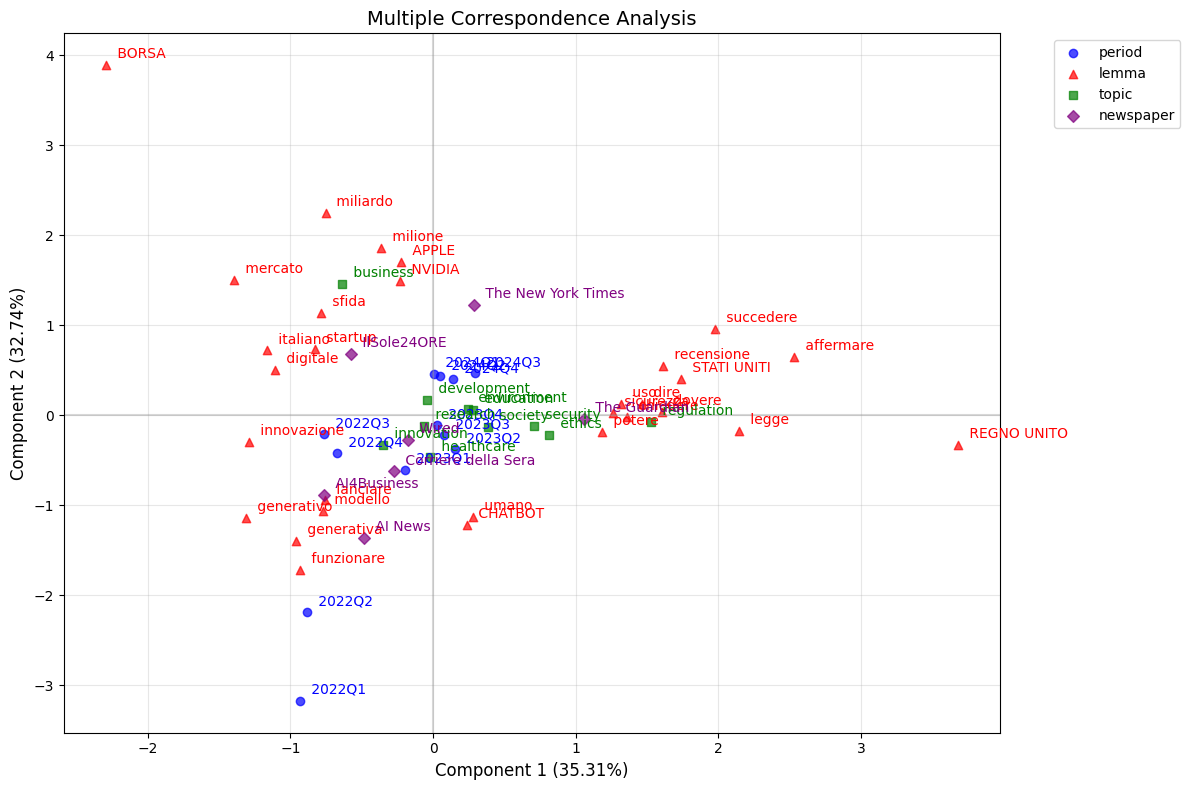


Explained variance ratio with 3 components chosen:
 Component 1: 35.31%
 Component 2: 32.74%
 Component 3: 31.95%
Total (sum of all components used): 100.00%


(MCA(n_components=3, random_state=42),
 <module 'matplotlib.pyplot' from 'D:\\PycharmProjects\\Thesis\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>)

In [79]:
columns_to_analyze = ['period', 'lemma', 'topic', 'newspaper']
prince_multiple_correspondence_analysis(df=df_to_mca,
                                 columns_to_analyze=columns_to_analyze,
                                 top_lemmas_for_analysis=80, n_components=None,
                                 lemmas_to_plot=30)